# Proyección con MEDGE en python

El Modelo de Proyección Trimestral (MPT) del BCRP es un modelo semiestructural basado en el marco neokeynesiano, diseñado para el análisis de una economía pequeña y abierta. Este modelo es útil para:

* Proyectar la evolución futura de la economía: Permite generar escenarios y pronósticos sobre las principales variables macroeconómicas.
* Analizar la coyuntura económica reciente: Facilita la evaluación del impacto de diversos eventos y políticas en la economía.

La versión que se estudiará en este curso, denominada "MPT de bolsillo", es una simplificación del modelo completo. A pesar de su simplificación, conserva los principales canales de transmisión de choques y de la política monetaria, lo que permite comprender los mecanismos fundamentales que operan en la economía peruana.

**Revisar**: Aguirre y otros (2022), Winkelried (2013), Vega y otros (2009).

En esta sesión nos enfocaremos en dos de las ecuaciones principales del modelo. 

## Curva de Phillips

$$\pi_t^{sae} = b_m \Pi_t^{m} + (1 - b_m) \left[b_{sae} \pi_{t-1}^{sae} + (1 - b_{sae}) \Pi_{t}^{e}\right] + b_y \left[c_y y_t + (1 - c_y) y_{t-1}\right] + \sigma_{\varepsilon^{\pi,sae}} \varepsilon_t^{sae} $$

## Regla de Taylor

**ALAN: chicos darle el mismo formato a esta ecuación**
$ i = \phi \cdot i_{-1} + (1 - \phi) \cdot \left( ieq + fp \cdot D4pdev + fy \cdot \left( cfy \cdot y + (1 - cfy) \cdot y_{(-1} \right) \right) + m\_res\_i \cdot res\_i $

**Tarea**: revisar el resto del MPT y sus canales de transmisión:
1. Impacto del sector externo (inflación, tasa externa, brecha externa y TI)
2. Impacto de choques fiscales
3. Impacto de la confianza empresarial/expectativas
4. Choques de costos

En general, la estimación de un modelo de equilibrio general (como un semiestructural o un DSGE), implica tres pasos:
1. Plantear el modelo teórico, i.e., canales de transmisión y relación entre variables a estudiar: Esto nos da la **forma estructural** el modelo
$$\mathbf{f}_{0}+\mathbf{f}_{y'}\mathrm{E}_t\mathbf{y}_{t+1}+\mathbf{f}_{y}\mathbf{y}_{t}+\mathbf{f}_{y^{\ell}}\mathbf{y}_{t-1}+\mathbf{f}_{u}\mathbf{u}_{t}=0$$
2. Resolver el modelo, se deben cuplir las condiciones de BK: De esto se obtiene la **forma reducida** el modelo
$$\mathbf{y}_{t} = \mathbf{g}_{0}+\mathbf{g}_{y}\mathbf{y}_{t-1}+\mathbf{g}_{u}\mathbf{u}_{t}$$
3. Reescribir el modelo como una representación de espacio estado:
$$\text{Medidas}:\quad\mathbf{z}_{t} = \mathbf{H}\mathbf{y}_{t}$$
$$\text{Estados}:\quad\mathbf{y}_{t} = \mathbf{g}_{0}+\mathbf{g}_{y}\mathbf{y}_{t-1}+\mathbf{g}_{u}\mathbf{u}_{t}$$
4. Con los datos, $\mathbf{z}_{t}$, el FK nos da la verosimilitud, si además se formulan los prior para los coeficientes, se puede etimar la posterior
5. Repetir 1-4 hasta maximizar la posterior, y luego implementar MH para simular la posterior


El modelo de esta sesión ya ha sido estimado

### Librerias requeridas

Configuración inicial para modo de ejecución

In [ ]:
flag_runlocal = True    # "False" para ejecutar en google colab

Las librerías a continuación han sido desarrolladas para estre curso. Éstas se encargan del procesamiento del modelo, la implementación numérica de la solución y calculos de productos asociados (IRF, KF y proyección), ademas del manejo de los datos.

In [ ]:
import sys
if flag_runlocal:
    # ---> Ejecución local
    pathPolMon = ''

else:
    # ---> Desde github-to-colab
    !git clone https://github.com/RondasDMM/CUECOPolMon.git
    pathPolMon = '/content/CUECOPolMon/'

sys.path.append(pathPolMon+'02_Libraries')
import DSGE_LinearMethods as DLM
import DSGE_PreProcessing as DPP
import HandleTimeSeries as HTS
import sympy as sp
sp.init_session(use_latex=True)

IPython console for SymPy 1.11.1 (Python 3.11.5-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.11.1/



Librería externas complementarias

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

### Procesamiento el modelo

La función ```process_file3``` lee el modelo y construye las funciones necesarias para computar la solución:

**ver modelo**: 04_Modelo/MPTBolsillo.txt

En ese archivo se declaran variables endógenas, exógenas y observables (recordar filtro de Kalman).


In [4]:
Mod = DPP.process_file3(pathPolMon+'04_Modelo/MPTBolsillo.txt')

El objeto de salida ```Mod``` es un diccionario con información sobre el modelo y funciones vinculadas a la forma estructural del modelo

In [5]:
Mod.keys()

dict_keys(['Desc.', 'FunMatForm', 'Rearranging_index', 'StateSpaceForm'])

### Solución del modelo

A continuación se resuelve el modelo y se verifican las condiciones de estabilidad.
Es necesario incluir una calibración de coeficientes y un estado estacionario (**ver**: 04_Modelo/Cal_MPTBolsillo.txt)

**Nota**: En caso deseen hacer cambios en coeficientes, estos deben ocurrir en esta etapa

In [6]:
Mod = DLM.SolveModel(Mod, pathPolMon+"04_Modelo/Cal_MPTBolsillo.txt", True)

-> Stability conditions met

Steady state
            User supplied  Numerical
DY_eq                5.30       5.30
DYs_eq               2.10       2.10
Ds                   0.00       0.00
y                    0.00       0.00
ys                   0.00       0.00
Dpae                 2.00       2.00
Dp                   2.00       2.00
Dp(-2)               2.00       2.00
Dp(-1)               2.00       2.00
D4p                  2.00       2.00
Dpsae                2.00       2.00
Dpsae(-2)            2.00       2.00
Dpsae(-1)            2.00       2.00
ED4p                 2.00       2.00
Dpm                  2.00       2.00
Dpm(-2)              2.00       2.00
Dpm(-1)              2.00       2.00
Meta                 2.00       2.00
i                    3.75       3.75
ieq                  3.75       3.75
zmn                  1.75       1.75
zme                  0.00       0.00
Ds(-2)               0.00       0.00
Ds(-1)               0.00       0.00
ED4s                 0.00       0

Ahora ```Mod``` contiene una llave adiciona: 'Solution'

In [7]:
Mod.keys()

dict_keys(['Desc.', 'FunMatForm', 'Rearranging_index', 'StateSpaceForm', 'Solution'])

### Estudio de las FIR

La función ```getIRF``` generar todos los FIRs

In [8]:
Horizon=20
IRF = DLM.getIRF(Mod,Horizon)

```IRF``` es un diccionario cuyas "keys" son los choques, dentro de cada "key" se encuentran las respuestas de todas las endogenas ante ese choques. 

El impulso (o choque) esta fijado en 1. Debido a que en el modelo se multiplica a los choques por su desviación estándar, entonces las respuestas son ante choques de 1 desviación estándar.

In [9]:
IRF.keys()

dict_keys(['res_DY_eq', 'res_Dpae', 'res_Dpsae', 'res_ED4p', 'res_Dpm', 'res_Meta', 'res_i', 'res_ieq', 'res_imn', 'res_zmn', 'res_ime', 'res_zme', 'res_Ds', 'res_ED4s', 'res_x', 'res_x_eq', 'res_DQ_eq', 'res_y', 'res_EDy', 'res_t', 'res_g', 'res_DTI', 'res_tau', 'res_DYs_eq', 'res_Dps', 'res_Dpms', 'res_iext', 'res_ys', 'res_ieqs', 'res_z'])

Por ejemplo, a continuación se pueden apreciar las respuestas ante un choque a la inflación AE

In [10]:
IRF['res_Dpae'].head(5)

,DY_eq,DYs_eq,Ds,y,ys,Dpae,Dp,Dp(-2),Dp(-1),D4p,...,D4s(+1),x,DQ,DQ_eq,D4ps,D4ps(+3),D4ps(+2),D4ps(+1),Rs,Rs_eq
0,0.0,0.0,-0.146240,-0.009528,0.0,3.956719,1.783490,0.000000,0.000000,0.445872,...,-0.087971,0.0,-1.929730,-0.354504,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,-0.205642,-0.010296,0.0,-0.042675,0.020465,0.000000,1.783490,0.450989,...,-0.147170,0.0,-0.226107,-0.330917,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,-0.236798,0.004243,0.0,-0.035848,0.040351,1.783490,0.020465,0.461076,...,-0.207973,0.0,-0.277149,-0.321039,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,-0.243212,0.020689,0.0,-0.028240,0.052125,0.020465,0.040351,0.474108,...,-0.228833,0.0,-0.295337,-0.316318,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,-0.229679,0.033654,0.0,-0.020052,0.058398,0.040351,0.052125,0.042835,...,-0.228523,0.0,-0.288077,-0.311130,0.0,0.0,0.0,0.0,0.0,0.0


Ejemplo para visualizar las respuestas 

$ Dpsae \rightarrow (ED4p, Dp) \rightarrow i$

$ i \rightarrow y \rightarrow (ED4p, Dpsae) \rightarrow Dp$

Text(0.5, 1.0, 'Respuestas de la TPM')

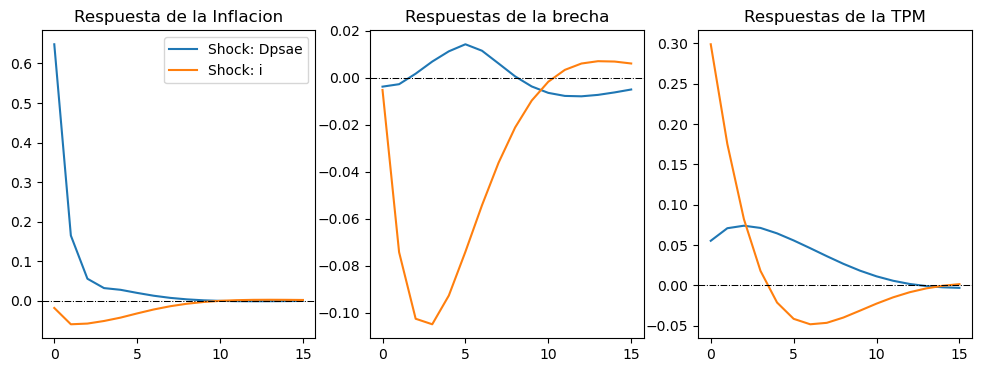

In [11]:
TP = 16   # Horizon to plot (<=Horizon)

shockslist = ['res_Dpsae','res_i']
varslist = ['Dp','y','i']

fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].plot(IRF[shockslist[0]].index[:TP], IRF[shockslist[0]][varslist[0]][:TP], linestyle='-',label="Shock: Dpsae")
axs[0].plot(IRF[shockslist[1]].index[:TP], IRF[shockslist[1]][varslist[0]][:TP], linestyle='-',label="Shock: i")
axs[0].axhline(y=0, color='black', linestyle='-.', linewidth=0.75)
axs[0].set_title("Respuesta de la Inflacion")
axs[0].legend(loc="best")

axs[1].plot(IRF[shockslist[0]].index[:TP], IRF[shockslist[0]][varslist[1]][:TP], linestyle='-',label="Shock: Dpsae")
axs[1].plot(IRF[shockslist[1]].index[:TP], IRF[shockslist[1]][varslist[1]][:TP], linestyle='-',label="Shock: i")
axs[1].axhline(y=0, color='black', linestyle='-.', linewidth=0.75)
axs[1].set_title("Respuestas de la brecha")

axs[2].plot(IRF[shockslist[0]].index[:TP], IRF[shockslist[0]][varslist[2]][:TP], linestyle='-',label="Shock: Dpsae")
axs[2].plot(IRF[shockslist[1]].index[:TP], IRF[shockslist[1]][varslist[2]][:TP], linestyle='-',label="Shock: i")
axs[2].axhline(y=0, color='black', linestyle='-.', linewidth=0.75)
axs[2].set_title("Respuestas de la TPM")

## Proyección

1. Se cargan los datos de variables observables. Estas se recaban de instituciones de estadísticas y se sintetizan para que sean insumidas por el modelo.

In [12]:
Describ, DBobs = HTS.ReadDB_excel(pathPolMon+'03_DB/DataClase.xlsx', sheet='DataSim')

Para la presentación de resultados, recogemos las variables endógenas y exógenas del modelo

In [13]:
var = DLM.sympy_to_list(Mod['Desc.']['Declared Endogenous'])
varexo = DLM.sympy_to_list(Mod['Desc.']['Shocks'])

Visualización de las variables medibles

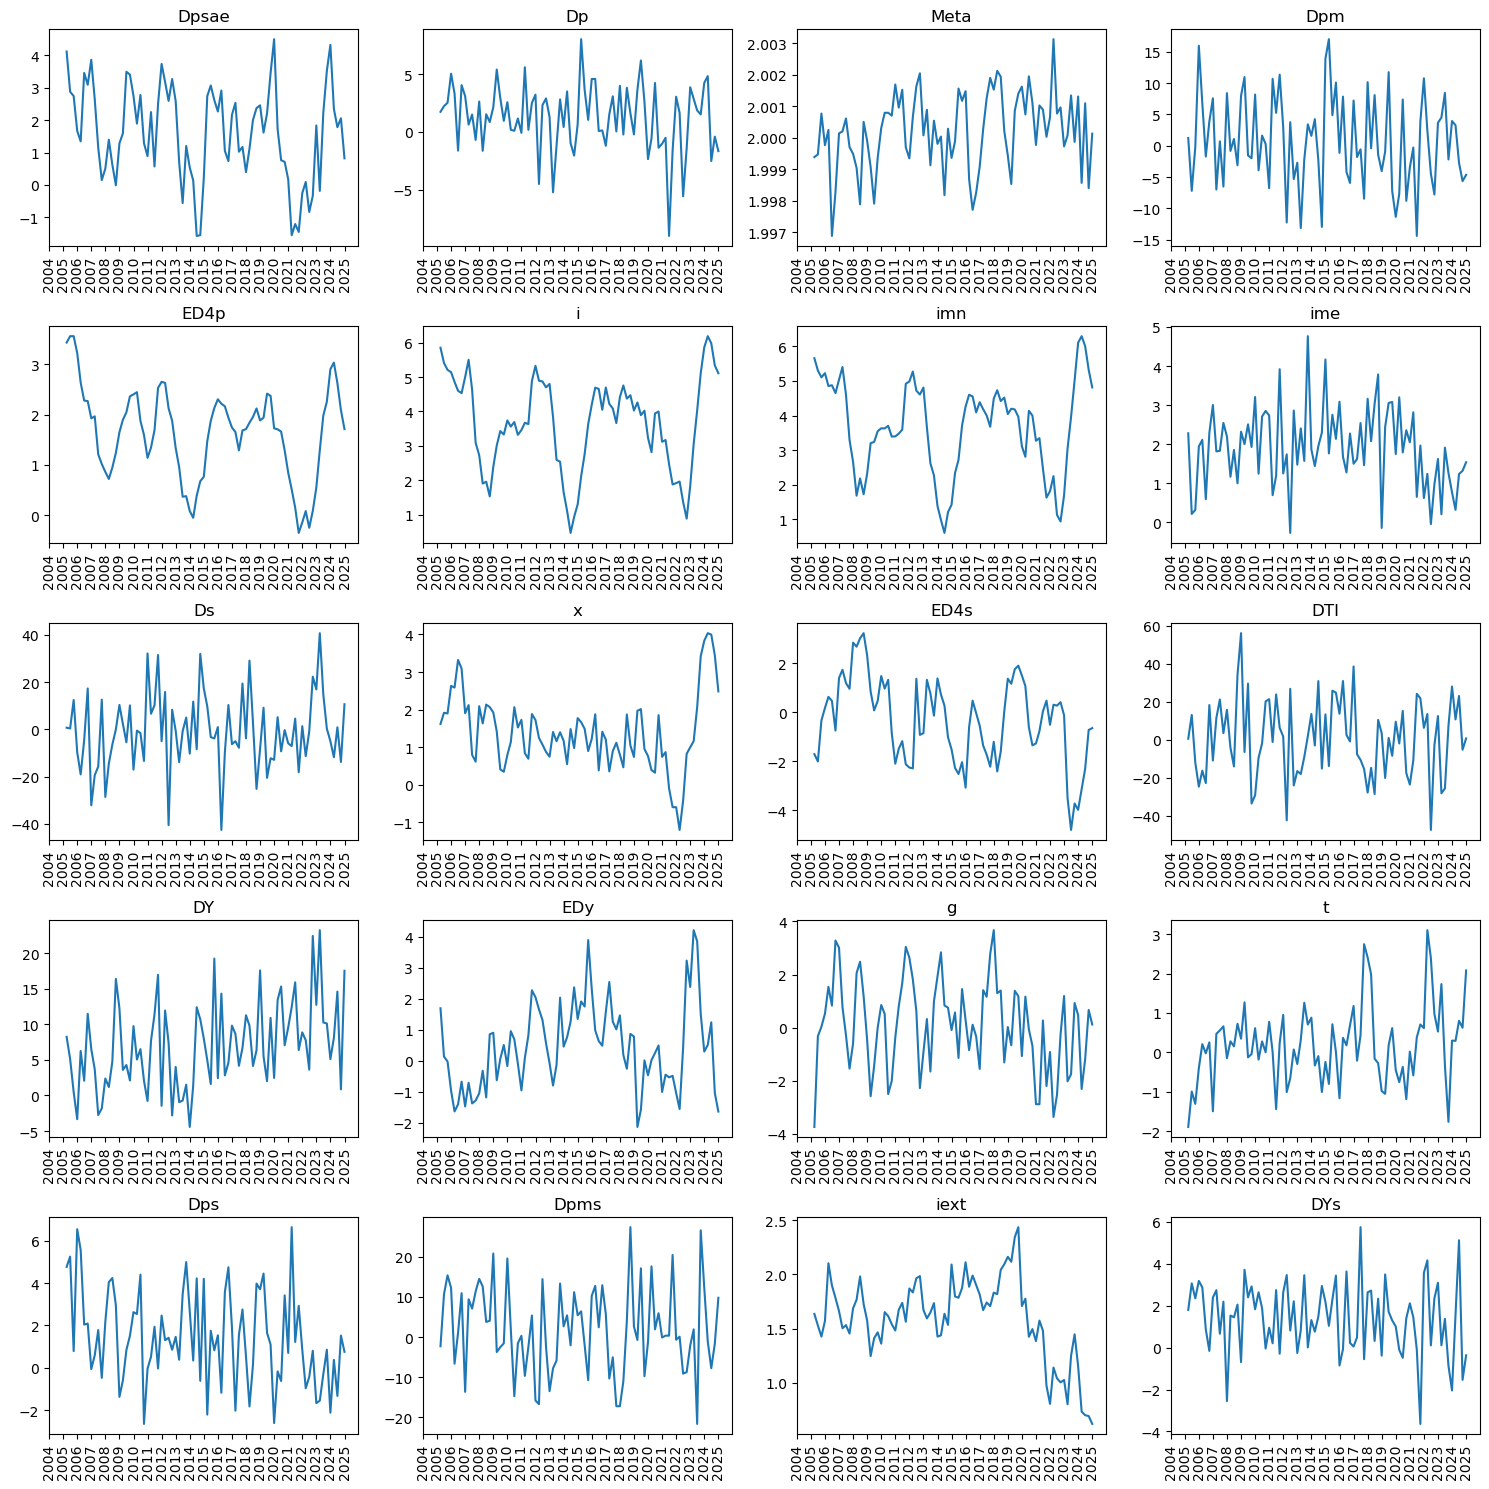

In [14]:
obsnames = DLM.sympy_to_list(Mod['StateSpaceForm']['obs_names'])
num_cols = len(obsnames)
num_rows = math.ceil(num_cols / 4)

fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 3))


for idx, col in enumerate(obsnames):
    row = idx // 4
    col_idx = idx % 4
    axs[row, col_idx].plot(DBobs.index, DBobs[col], linestyle='-')
    axs[row, col_idx].set_title(col)
    axs[row, col_idx].tick_params(axis='x', rotation = 90)
    axs[row, col_idx].set_xticks(axs[row, col_idx].get_xticks()[::4])

    axs[row, col_idx].xaxis.set_major_locator(mdates.YearLocator())
    axs[row, col_idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for idx in range(num_cols, num_rows * 4):
    fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()

2. Con el filtro de Kalman se estiman las variables no observables, consistente con la estructura del MPT.

In [15]:
DF_s, DF_u, minuslogL = DLM.KFts(DBobs, Mod, {'diffuse':False}) 
# DF_s:  smoothed
# DF_u:  updated
Data = DF_s
Data.tail(4)

,DY_eq,DYs_eq,Ds,y,ys,Dpae,Dp,Dp(-2),Dp(-1),D4p,...,D4s(+1),x,DQ,DQ_eq,D4ps,D4ps(+3),D4ps(+2),D4ps(+1),Rs,Rs_eq
2024-03-31,10.290252,0.912048,-11.787625,2.168047,-0.777874,7.919626,4.837940,1.516487,4.257113,3.118131,...,-5.172842,4.034443,-16.249512,0.863371,-0.297248,1.015215,0.155513,0.053014,-0.523699,-0.630713
2024-06-30,10.233764,0.820194,0.855975,3.258012,0.298336,-7.852865,-2.528060,4.257113,4.837940,2.020870,...,-4.841661,3.997241,2.056830,1.082653,-0.553297,0.539671,0.295376,-0.553502,-0.510947,-0.816915
2024-09-30,10.237024,0.752372,-13.778202,0.913280,-0.274179,-3.461596,-0.412276,4.837940,-2.528060,1.538679,...,-6.594826,3.447080,-11.842450,-1.291769,-0.386529,1.351445,0.698766,0.472106,-0.599628,-0.913696
2024-12-31,10.263720,0.731688,10.617072,2.726578,-0.548806,-4.742201,-1.667825,-2.528060,-0.412276,0.057444,...,-1.545766,2.485003,13.042037,1.341329,0.332366,1.084200,1.153909,0.519066,-0.589979,-0.890124


<Axes: >

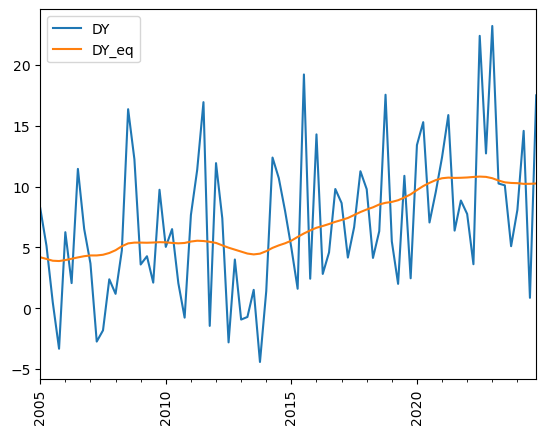

In [16]:
Data[['DY', 'DY_eq']].plot.line(rot = 90)

3. Ejemplos de proyección

**Proyección incondicional**

Se proyectarán 8 trimestres desde el último periodo de información 2024Q4. 

La proyección es libre de condicionantes. En consecuencia, se observa la convergencia de la economía hacia su estado estacionario, tomando como punto de partida la situación inicial. Cabe destacar que ciertas variables presentan dependencia de múltiples rezagos.

In [17]:
FH = 8 # Horizonte de proyección (2 años)
StartingPeriod = '2025Q1'
FDB = DLM.DSGEforecast0(Mod,Data,FH,StartingPeriod)

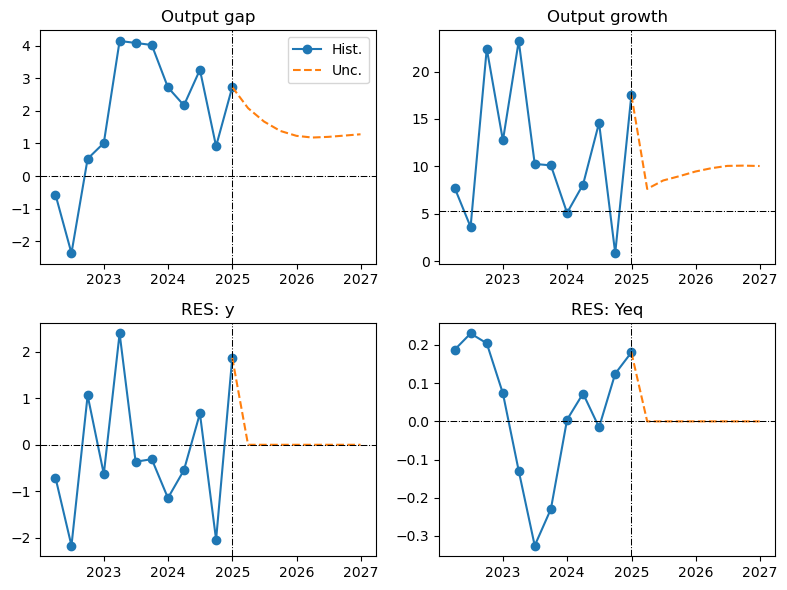

In [18]:
DBdict = {'Unc.': FDB}
lista = ['y','DY','res_y','res_DY_eq']
listanames = ['Output gap','Output growth','RES: y','RES: Yeq']
listaSS = [0,5.3,0,0]
HH = 12
Number_Rows = 2
Number_Cols = 2
fig, axs = HTS.plotTSforecast(DBdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

**Proyección condicionada**

Es posible incorporar al modelo proyecciones externas para variables tanto observables como no observables, actuando como condicionantes. El Modelo de Proyección Trimestral (MPT) ajustará sus resultados en función de estas trayectorias predefinidas (hardtuning). Las variables restantes se adaptarán a la información ingresada, siguiendo las relaciones establecidas por las ecuaciones y los canales de transmisión del modelo. Los choques (residuos) funcionarán como mecanismos de ajuste, absorbiendo las discrepancias entre las variables proyectadas externamente y las explicadas por el modelo.

Por ejemplo, se podría introducir una proyección externa sobre la evolución de la tasa de interés de la Reserva Federal (FED), aunque esta no esté modelada explícitamente (la parte externa representa una simplificación). Esta información, basada en juicio experto o modelos satélite, se incorpora como un dato exógeno.

En la presente sesión, se analizará el impacto de un choque positivo en la demanda, que impulsará la brecha del producto. Adicionalmente, se observará una reacción más pronunciada de la inflación subyacente.

Para este ejercicio, se proponen dos escenarios de análisis:
- **Escenario 1**: Tasa de interés libre. Este escenario permite examinar el efecto conjunto del choque y la reacción del banco central, siguiendo la regla de Taylor. Proporciona una estimación del comportamiento probable del banco central.
- **Escenario 2**: Tasa de interés fija. Este escenario evalúa el impacto del choque, asumiendo que el banco central mantiene la tasa de interés en el nivel del escenario base, sin reaccionar.

In [19]:
UCond = HTS.ReadForeCond(pathPolMon+'03_DB/DataClase_Exogenas.xlsx','2025Q1', FH)

tpmfija = True

if tpmfija:
    UCond['Uvar']['var']['i'] = FDB.i
    UCond['Uvar']['shock'].append('res_i')

In [20]:
print('Which are the assumptions?')
print('Unanticipated Softtunning')
print(UCond['UShock'])
print('Unanticipated Hardtunning')
print(UCond['Uvar']['var'])
print('-> Shocks to achieve hardtunning:')
print(UCond['Uvar']['shock'])

Which are the assumptions?
Unanticipated Softtunning
            res_Dps
2025-03-31      NaN
2025-06-30      NaN
2025-09-30      NaN
2025-12-31      NaN
2026-03-31      NaN
2026-06-30      NaN
2026-09-30      NaN
2026-12-31      NaN
Unanticipated Hardtunning
               Dpsae         y         i
2025-03-31  2.987568  2.075458  4.811568
2025-06-30  1.998147  1.815400  4.504615
2025-09-30  2.000552  1.528940  4.228667
2025-12-31  2.034655  1.402530  3.997910
2026-03-31  2.058835  1.339901  3.827929
2026-06-30  2.084970  1.360376  3.718169
2026-09-30  2.103786  1.396791  3.657818
2026-12-31  2.112211  1.435756  3.632011
-> Shocks to achieve hardtunning:
['res_Dpsae', 'res_y', 'res_i']


In [21]:
UFDB = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond)

El impacto de los riesgos se mide como la suma ponderada de las variables de interés. En este caso es la inflación final de cada año. Así se sigue:

$$\pi_t^{escenarios} - \pi_t $$

$$\pi_t^{escenarios} = \pi_t * (1 - p_i) + \pi_t^{riesgo}*p_i $$

Reemplazando:

$$ (\pi_t^{riesgo} - \pi_t)*p_i  $$

In [22]:
print(f'Impacto 2025: {round((UFDB.D4p[-5:-4][0] - FDB.D4p[-5:-4][0])*0.10, 2)}')
print(f'Impacto 2026: {round((UFDB.D4p[-1:][0] - FDB.D4p[-1:][0])*0.10, 2)}')

Impacto 2025: 0.06
Impacto 2026: 0.05


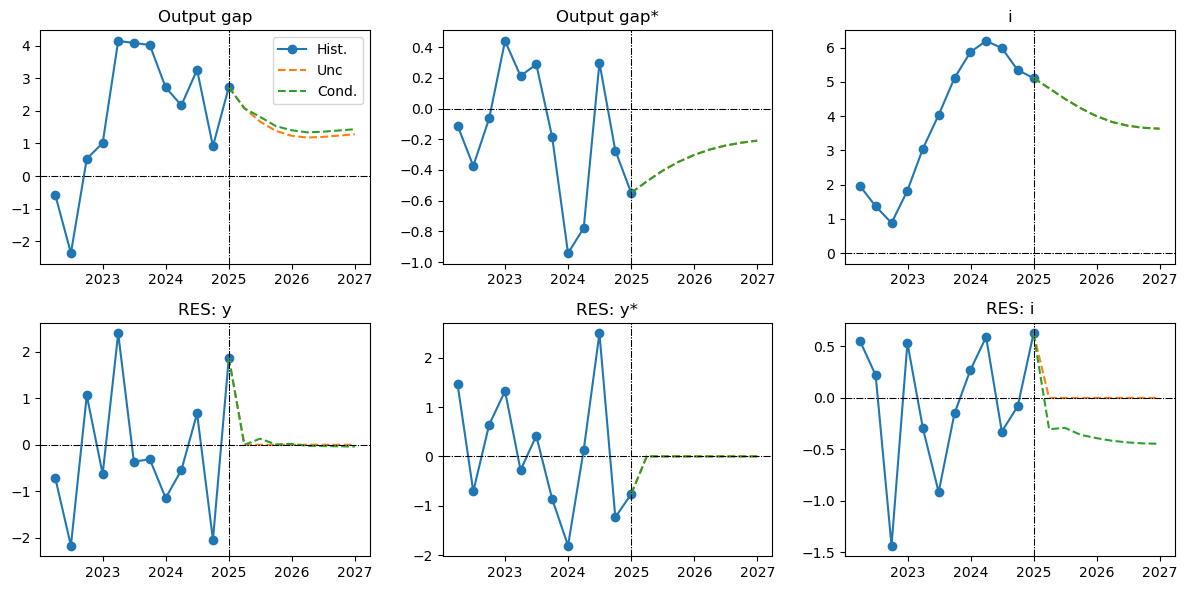

In [23]:
BDdict = {'Unc': FDB,'Cond.': UFDB}
lista = ['y','ys', 'i','res_y','res_ys', 'res_i']
listanames = ['Output gap','Output gap*', 'i','RES: y','RES: y*', 'RES: i']
listaSS = [0,0,0,0,0,0]
HH = 12
Number_Rows = 2
Number_Cols = 3
fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

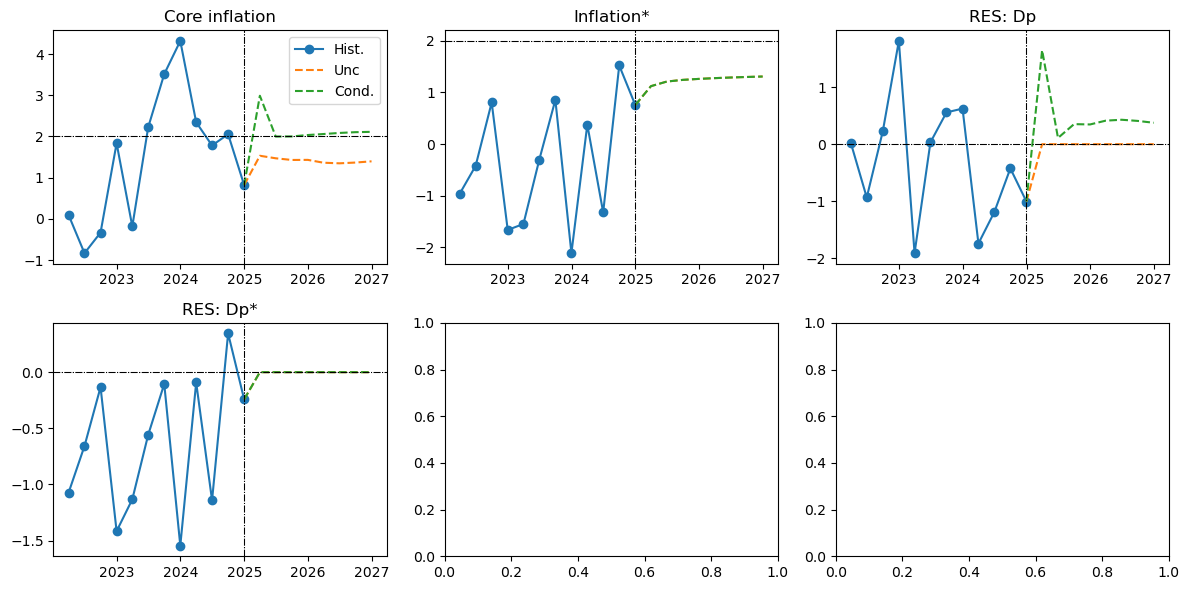

In [24]:
lista = ['Dpsae','Dps','res_Dpsae','res_Dps']
listanames = ['Core inflation','Inflation*','RES: Dp','RES: Dp*']
listaSS = [2,2,0,0]
fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

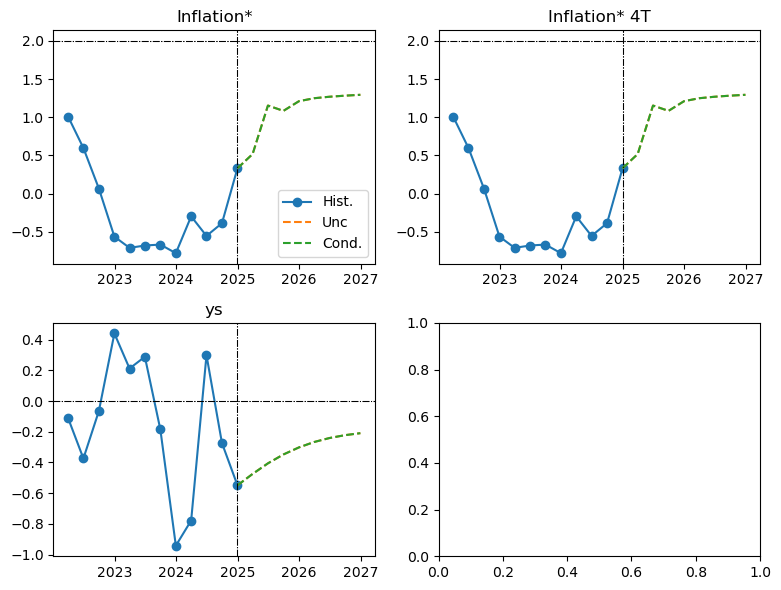

In [25]:
# Dps = bsp*Dps(-1) + (1 - bsp)*D4ps(+4) + bsy*ys(-1) + res_Dps
lista   = ['D4ps','D4ps','ys']
listaSS = [2,2,0]
listanames = ['Inflation*','Inflation* 4T','ys']

fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,2,2)

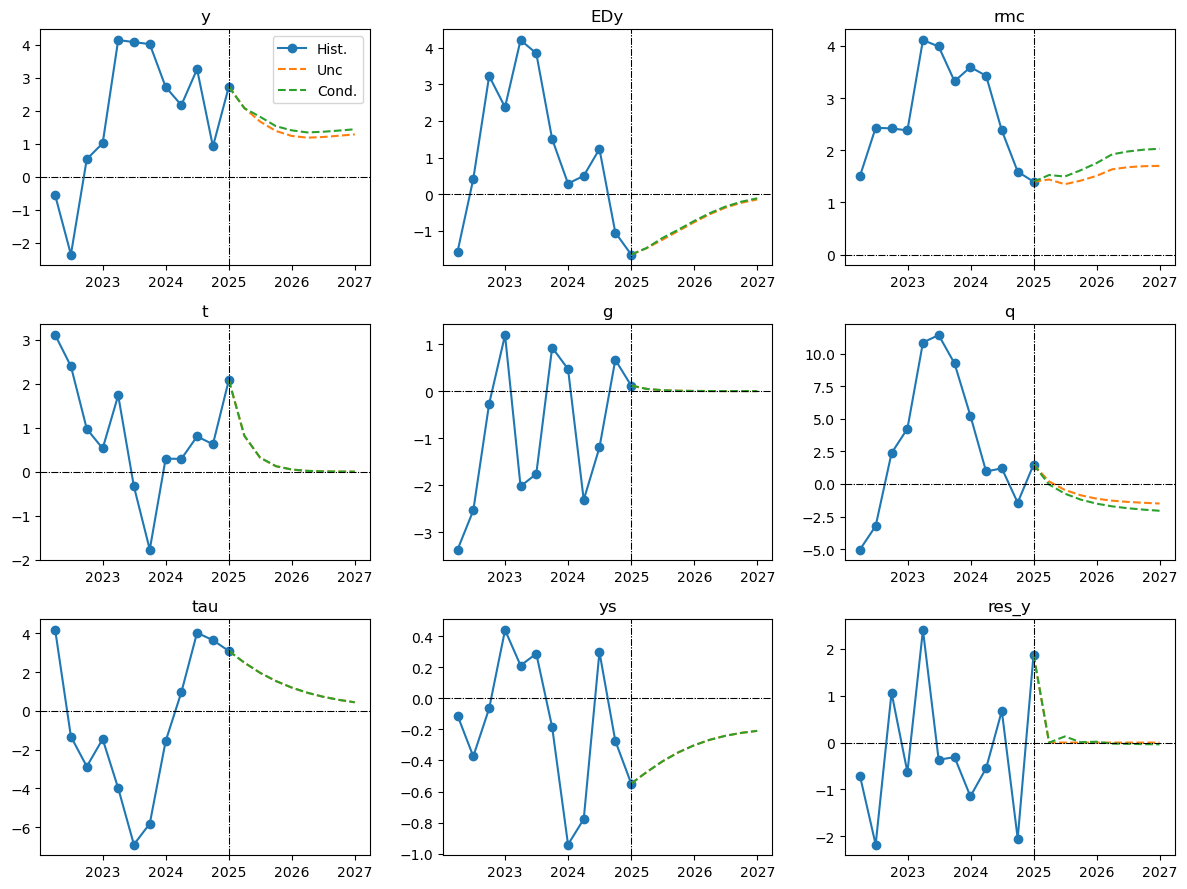

In [26]:
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y
lista   = ['y','EDy','rmc','t','g','q','tau','ys','res_y']
listaSS = [0,0,0,0,0,0,0,0,0]
listanames = lista

fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH,3,3)

In [27]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['Brecha: y','Inercia: (ay+aEy)*y(-1)','Confianza: aEy*EDy','Cond. Mon.: armc*rmc(-1)','Imp. Rec.: -at*t','Imp. gasto: ag*g','TCRM: aq*q','Imp. TI: atau*tau','Socios: ays*ys','Res.: m_res_y*res_y'], index=UFDB.index[-(hist2show+FH):]).T

,2024-03-31,2024-06-30,2024-09-30,2024-12-31,2025-03-31,2025-06-30,2025-09-30,2025-12-31,2026-03-31,2026-06-30,2026-09-30,2026-12-31
Brecha: y,2.168047,3.258012,0.913280,2.726578,2.075458,1.815400,1.528940,1.402530,1.339901,1.360376,1.396791,1.435756
Inercia: (ay+aEy)*y(-1),1.813384,1.446521,2.173746,0.609341,1.819173,1.384746,1.211235,1.020109,0.935768,0.893982,0.907643,0.931939
Confianza: aEy*EDy,0.064309,0.157597,-0.133282,-0.209855,-0.186863,-0.152272,-0.123302,-0.092949,-0.065874,-0.042869,-0.025877,-0.013969
Cond. Mon.: armc*rmc(-1),1.078250,1.028663,0.713988,0.477113,0.418862,0.457560,0.448967,0.485031,0.526374,0.576418,0.593042,0.603400
Imp. Rec.: -at*t,-0.001455,-0.004003,-0.003122,-0.010396,-0.004079,-0.001600,-0.000628,-0.000246,-0.000097,-0.000038,-0.000015,-0.000006
Imp. gasto: ag*g,-0.266398,-0.138038,0.076564,0.013368,0.005363,0.002152,0.000863,0.000346,0.000139,0.000056,0.000022,0.000009
TCRM: aq*q,0.022250,0.027900,-0.033294,0.034570,-0.000933,-0.017185,-0.027849,-0.035023,-0.039837,-0.043199,-0.045704,-0.047705
Imp. TI: atau*tau,0.019648,0.082457,0.074588,0.063216,0.050903,0.040169,0.031436,0.024514,0.019088,0.014853,0.011555,0.008988
Socios: ays*ys,-0.042861,0.016438,-0.015107,-0.030239,-0.026154,-0.022357,-0.019173,-0.016645,-0.014713,-0.013284,-0.012256,-0.011535
Res.: m_res_y*res_y,-0.519078,0.640476,-1.940799,1.779460,-0.000814,0.124188,0.007391,0.017393,-0.020947,-0.025543,-0.031619,-0.035364
